# 1. Creación de Escenarios y Particiones por Consulta Clínica para cada día del Set de Pruebas.

## 1.1 Importación de Librerías y Carga del Set de Pruebas heredado de la Fase 1 - Predicción de No Shows.

In [1]:
import pandas as pd
from datetime import datetime
import random

from openpyxl import Workbook
from openpyxl.styles import Alignment
from openpyxl.utils.dataframe import dataframe_to_rows

In [2]:
# Ruta del archivo CSV con los datos del Set de Pruebas
file_path = "./test_set_P1-ALL-ADASYN con Prob_No_Show_TabNet.xlsx"

# Leer el archivo EXCEL
test_set_full = pd.read_excel(file_path)

# Nos quedamos con el contenido que necesitamos: 'PatientId', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Prob_NoShow'
test_set = test_set_full[['PatientId', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Prob_NoShow']]

# Convertimos 'ScheduledDay' y 'AppointmentDay' a datetime
pd.options.mode.copy_on_write = True
test_set['ScheduledDay'] = pd.to_datetime(test_set['ScheduledDay'])
test_set['AppointmentDay'] = pd.to_datetime(test_set['AppointmentDay'])

# Mostrar el contenido del DataFrame
test_set

PatientId        ScheduledDay AppointmentDay  NoShow  Prob_NoShow
0        1216586867796 2015-12-07 10:40:59     2016-06-03    True     0.564009
1       31899595421534 2015-12-07 10:42:42     2016-06-03   False     0.536110
2        9582232334148 2015-12-07 10:43:01     2016-06-03   False     0.393693
3        3516253533716 2015-12-07 10:43:17     2016-06-03   False     0.371280
4         454287126844 2015-12-07 10:43:34     2016-06-03   False     0.446127
...                ...                 ...            ...     ...          ...
22092  729255235141745 2016-06-08 19:32:25     2016-06-08   False     0.030953
22093  947614361749238 2016-06-08 19:32:56     2016-06-08   False     0.125537
22094     356247857784 2016-06-08 19:33:23     2016-06-08   False     0.045798
22095     234131759175 2016-06-08 19:58:52     2016-06-08   False     0.045798
22096    5237164264312 2016-06-08 20:07:23     2016-06-08   False     0.066827

[22097 rows x 5 columns]

In [3]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22097 entries, 0 to 22096
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PatientId       22097 non-null  int64         
 1   ScheduledDay    22097 non-null  datetime64[ns]
 2   AppointmentDay  22097 non-null  datetime64[ns]
 3   NoShow          22097 non-null  bool          
 4   Prob_NoShow     22097 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 712.2 KB


## 1.2 Creación de Set de Entrenamiento y Set de Validación.

Reservamos un 20% de los datos para verificar la Optimización en la Programación de Citas Médicas una vez entrenado el modelo.

In [4]:
# Calculate the total number of NoShows
total_no_shows = test_set['NoShow'].sum()

# Calculate the number of NoShows for each dataset
no_shows_80_percent = int(total_no_shows * 0.8)
no_shows_20_percent = total_no_shows - no_shows_80_percent

# Split the dataset into two based on the calculated proportions
train_set = test_set[test_set['NoShow'] == 0].sample(frac = 0.8, random_state = 42)
train_set = pd.concat([
        train_set,
        test_set[test_set['NoShow'] == 1].sample(n = no_shows_80_percent, random_state = 42)
])

val_set = test_set.drop(train_set.index)

# Verify the proportions of NoShows in each dataset
proportion_NoShows_train_set = train_set['NoShow'].mean()
proportion_NoShows_val_set = val_set['NoShow'].mean()

print(f'Proporción de NoShows en el Set de Entrenamiento: {proportion_NoShows_train_set:.4f}')
print(f'Proporción de NoShows en el Set de Validación: {proportion_NoShows_val_set:.4f}')

Proporción de NoShows en el Set de Entrenamiento: 0.2018
Proporción de NoShows en el Set de Validación: 0.2020


## 1.3 Separación de datos por 'AppointmentDay'.

Agrupamos los datos por 'AppointmentDay', revisamos y guardamos dichos subconjuntos. Aunque esto sólo será de aplicación cuando entrenemos el algoritmo de ML que calcule los mejores spots para generar el overbooking.

In [5]:
# Group the DataFrame by 'AppointmentDay'
grouped_train_data = train_set.groupby('AppointmentDay')
grouped_val_data = val_set.groupby('AppointmentDay')

# Create a dictionary to store the smaller datasets
train_datasets = {}
val_datasets = {}

# Iterate over each group and store the corresponding dataset in the dictionary
for day, group in grouped_train_data:
    train_datasets[day] = group
for day, group in grouped_val_data:
    val_datasets[day] = group

# Access, review and store the datasets for specific days
train_set_May30 = train_datasets[datetime(2016, 5, 30)]
print(f"El set de entrenamiento para el 30 de mayo de 2016 tiene \
{train_set_May30.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_May30['NoShow'].mean():.2%}.")
val_set_May30 = val_datasets[datetime(2016, 5, 30)]
print(f"El set de validación para el 30 de mayo de 2016 tiene \
{val_set_May30.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_May30['NoShow'].mean():.2%}.")
print("\033[1mDescartamos los datos del 30 de mayo de 2016 por \
insuficiencia y por ser todos No Show.\033[0m\n")

train_set_May31 = train_datasets[datetime(2016, 5, 31)]
print(f"El set de entrenamiento para el 31 de mayo de 2016 tiene \
{train_set_May31.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_May31['NoShow'].mean():.2%}.")
val_set_May31 = val_datasets[datetime(2016, 5, 31)]
print(f"El set de validación para el 31 de mayo de 2016 tiene \
{val_set_May31.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_May31['NoShow'].mean():.2%}.")
print("\033[1mDescartamos los datos del 31 de mayo de 2016 porque \
el alto número de No Shows desvirtuan la programación y cálculo de los costes.\033[0m\n")

train_set_June01 = train_datasets[datetime(2016, 6, 1)]
print(f"El set de entrenamiento para el 1 de junio de 2016 tiene \
{train_set_June01.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June01['NoShow'].mean():.2%}.")
val_set_June01 = val_datasets[datetime(2016, 6, 1)]
print(f"El set de validación para el 1 de junio de 2016 tiene \
{val_set_June01.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June01['NoShow'].mean():.2%}.\n")

train_set_June02 = train_datasets[datetime(2016, 6, 2)]
print(f"El set de entrenamiento para el 2 de junio de 2016 tiene \
{train_set_June02.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June02['NoShow'].mean():.2%}.")
val_set_June02 = val_datasets[datetime(2016, 6, 2)]
print(f"El set de validación para el 2 de junio de 2016 tiene \
{val_set_June02.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June02['NoShow'].mean():.2%}.\n")

train_set_June03 = train_datasets[datetime(2016, 6, 3)]
print(f"El set de entrenamiento para el 3 de junio de 2016 tiene \
{train_set_June03.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June03['NoShow'].mean():.2%}.")
val_set_June03 = val_datasets[datetime(2016, 6, 3)]
print(f"El set de validación para el 3 de junio de 2016 tiene \
{val_set_June03.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June03['NoShow'].mean():.2%}.\n")

train_set_June06 = train_datasets[datetime(2016, 6, 6)]
print(f"El set de entrenamiento para el 6 de junio de 2016 tiene \
{train_set_June06.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June06['NoShow'].mean():.2%}.")
val_set_June06 = val_datasets[datetime(2016, 6, 6)]
print(f"El set de validación para el 6 de junio de 2016 tiene \
{val_set_June06.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June06['NoShow'].mean():.2%}.\n")

train_set_June07 = train_datasets[datetime(2016, 6, 7)]
print(f"El set de entrenamiento para el 7 de junio de 2016 tiene \
{train_set_June07.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June07['NoShow'].mean():.2%}.")
val_set_June07 = val_datasets[datetime(2016, 6, 7)]
print(f"El set de validación para el 7 de junio de 2016 tiene \
{val_set_June07.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June07['NoShow'].mean():.2%}.\n")

train_set_June08 = train_datasets[datetime(2016, 6, 8)]
print(f"El set de entrenamiento para el 8 de junio de 2016 tiene \
{train_set_June08.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June08['NoShow'].mean():.2%}.")
val_set_June08 = val_datasets[datetime(2016, 6, 8)]
print(f"El set de validación para el 8 de junio de 2016 tiene \
{val_set_June08.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June08['NoShow'].mean():.2%}.\n")

print("\033[1mREHACEMOS TODO EL PROCESO DESCARTANDO LOS DATOS DEL 30 Y 31 DE MAYO.\033[0m\n")

El set de entrenamiento para el 30 de mayo de 2016 tiene 45 citas, con un porcentaje de NoShows del 100.00%.
El set de validación para el 30 de mayo de 2016 tiene 15 citas, con un porcentaje de NoShows del 100.00%.
Descartamos los datos del 30 de mayo de 2016 por insuficiencia y por ser todos No Show.

El set de entrenamiento para el 31 de mayo de 2016 tiene 613 citas, con un porcentaje de NoShows del 66.72%.
El set de validación para el 31 de mayo de 2016 tiene 152 citas, con un porcentaje de NoShows del 67.11%.
Descartamos los datos del 31 de mayo de 2016 porque el alto número de No Shows desvirtuan la programación y cálculo de los costes.

El set de entrenamiento para el 1 de junio de 2016 tiene 2472 citas, con un porcentaje de NoShows del 18.16%.
El set de validación para el 1 de junio de 2016 tiene 589 citas, con un porcentaje de NoShows del 21.22%.

El set de entrenamiento para el 2 de junio de 2016 tiene 2582 citas, con un porcentaje de NoShows del 18.20%.
El set de validación p

In [6]:
# Quitamos las citas del 30 y 31 de mayo.
new_test_set = test_set[~test_set['AppointmentDay'].dt.strftime('%Y-%m-%d').isin(['2016-05-30', '2016-05-31'])]

print(new_test_set[new_test_set['AppointmentDay'] == datetime(2016, 5, 30)])
print(new_test_set[new_test_set['AppointmentDay'] == datetime(2016, 5, 31)])
new_test_set

Empty DataFrame
Columns: [PatientId, ScheduledDay, AppointmentDay, NoShow, Prob_NoShow]
Index: []
Empty DataFrame
Columns: [PatientId, ScheduledDay, AppointmentDay, NoShow, Prob_NoShow]
Index: []


PatientId        ScheduledDay AppointmentDay  NoShow  Prob_NoShow
0        1216586867796 2015-12-07 10:40:59     2016-06-03    True     0.564009
1       31899595421534 2015-12-07 10:42:42     2016-06-03   False     0.536110
2        9582232334148 2015-12-07 10:43:01     2016-06-03   False     0.393693
3        3516253533716 2015-12-07 10:43:17     2016-06-03   False     0.371280
4         454287126844 2015-12-07 10:43:34     2016-06-03   False     0.446127
...                ...                 ...            ...     ...          ...
22092  729255235141745 2016-06-08 19:32:25     2016-06-08   False     0.030953
22093  947614361749238 2016-06-08 19:32:56     2016-06-08   False     0.125537
22094     356247857784 2016-06-08 19:33:23     2016-06-08   False     0.045798
22095     234131759175 2016-06-08 19:58:52     2016-06-08   False     0.045798
22096    5237164264312 2016-06-08 20:07:23     2016-06-08   False     0.066827

[21272 rows x 5 columns]

In [7]:
# Quitamos las citas solicitadas para el mismo día del appointment.
new_test_set = new_test_set[new_test_set['ScheduledDay'].dt.strftime('%Y-%m-%d') != new_test_set['AppointmentDay'].dt.strftime('%Y-%m-%d')]

new_test_set

PatientId        ScheduledDay AppointmentDay  NoShow  Prob_NoShow
0       1216586867796 2015-12-07 10:40:59     2016-06-03    True     0.564009
1      31899595421534 2015-12-07 10:42:42     2016-06-03   False     0.536110
2       9582232334148 2015-12-07 10:43:01     2016-06-03   False     0.393693
3       3516253533716 2015-12-07 10:43:17     2016-06-03   False     0.371280
4        454287126844 2015-12-07 10:43:34     2016-06-03   False     0.446127
...               ...                 ...            ...     ...          ...
20720   1957317441772 2016-06-07 18:35:36     2016-06-08   False     0.590582
20724  77213369861559 2016-06-07 18:52:29     2016-06-08   False     0.816563
20725   6413391347676 2016-06-07 18:58:48     2016-06-08   False     0.578954
20726  75838484541313 2016-06-07 19:01:01     2016-06-08   False     0.740746
20728  36657393652886 2016-06-07 19:03:57     2016-06-08   False     0.685905

[14154 rows x 5 columns]

In [8]:
new_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14154 entries, 0 to 20728
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PatientId       14154 non-null  int64         
 1   ScheduledDay    14154 non-null  datetime64[ns]
 2   AppointmentDay  14154 non-null  datetime64[ns]
 3   NoShow          14154 non-null  bool          
 4   Prob_NoShow     14154 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 566.7 KB


In [9]:
# Calculate the total number of NoShows
total_no_shows = new_test_set['NoShow'].sum()

# Calculate the number of NoShows for each dataset
no_shows_80_percent = int(total_no_shows * 0.8)
no_shows_20_percent = total_no_shows - no_shows_80_percent

# Split the dataset into two based on the calculated proportions
train_set = new_test_set[new_test_set['NoShow'] == 0].sample(frac = 0.8, random_state = 42)
train_set = pd.concat([train_set,
        new_test_set[new_test_set['NoShow'] == 1].sample(n = no_shows_80_percent, random_state = 42)])

val_set = new_test_set.drop(train_set.index)

# Verify the proportions of NoShows in each dataset
proportion_NoShows_train_set = train_set['NoShow'].mean()
proportion_NoShows_val_set = val_set['NoShow'].mean()

print(f'Proporción de NoShows en el Set de Entrenamiento: {proportion_NoShows_train_set:.4f}')
print(f'Proporción de NoShows en el Set de Validación: {proportion_NoShows_val_set:.4f}')

Proporción de NoShows en el Set de Entrenamiento: 0.2593
Proporción de NoShows en el Set de Validación: 0.2593


In [10]:
# Group the DataFrame by 'AppointmentDay'
grouped_total_data = new_test_set.groupby('AppointmentDay')
grouped_train_data = train_set.groupby('AppointmentDay')
grouped_val_data = val_set.groupby('AppointmentDay')

# Create a dictionary to store the smaller datasets
total_datasets = {}
train_datasets = {}
val_datasets = {}

# Iterate over each group and store the corresponding dataset in the dictionary
for day, group in grouped_total_data:
    total_datasets[day] = group
for day, group in grouped_train_data:
    train_datasets[day] = group
for day, group in grouped_val_data:
    val_datasets[day] = group

# Access, review and store the datasets for specific days
total_set_June01 = total_datasets[datetime(2016, 6, 1)]
print(f"El set con todas las citas médicas para el 1 de junio de 2016 tiene \
{total_set_June01.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June01['NoShow'].mean():.2%}.")
train_set_June01 = train_datasets[datetime(2016, 6, 1)]
print(f"El set de entrenamiento para el 1 de junio de 2016 tiene \
{train_set_June01.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June01['NoShow'].mean():.2%}.")
val_set_June01 = val_datasets[datetime(2016, 6, 1)]
print(f"El set de validación para el 1 de junio de 2016 tiene \
{val_set_June01.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June01['NoShow'].mean():.2%}.\n")

total_set_June02 = total_datasets[datetime(2016, 6, 2)]
print(f"El set con todas las citas médicas para el 2 de junio de 2016 tiene \
{total_set_June02.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June02['NoShow'].mean():.2%}.")
train_set_June02 = train_datasets[datetime(2016, 6, 2)]
print(f"El set de entrenamiento para el 2 de junio de 2016 tiene \
{train_set_June02.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June02['NoShow'].mean():.2%}.")
val_set_June02 = val_datasets[datetime(2016, 6, 2)]
print(f"El set de validación para el 2 de junio de 2016 tiene \
{val_set_June02.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June02['NoShow'].mean():.2%}.\n")

total_set_June03 = total_datasets[datetime(2016, 6, 3)]
print(f"El set con todas las citas médicas para el 3 de junio de 2016 tiene \
{total_set_June03.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June03['NoShow'].mean():.2%}.")
train_set_June03 = train_datasets[datetime(2016, 6, 3)]
print(f"El set de entrenamiento para el 3 de junio de 2016 tiene \
{train_set_June03.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June03['NoShow'].mean():.2%}.")
val_set_June03 = val_datasets[datetime(2016, 6, 3)]
print(f"El set de validación para el 3 de junio de 2016 tiene \
{val_set_June03.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June03['NoShow'].mean():.2%}.\n")

total_set_June06 = total_datasets[datetime(2016, 6, 6)]
print(f"El set con todas las citas médicas para el 6 de junio de 2016 tiene \
{total_set_June06.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June06['NoShow'].mean():.2%}.")
train_set_June06 = train_datasets[datetime(2016, 6, 6)]
print(f"El set de entrenamiento para el 6 de junio de 2016 tiene \
{train_set_June06.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June06['NoShow'].mean():.2%}.")
val_set_June06 = val_datasets[datetime(2016, 6, 6)]
print(f"El set de validación para el 6 de junio de 2016 tiene \
{val_set_June06.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June06['NoShow'].mean():.2%}.\n")

total_set_June07 = total_datasets[datetime(2016, 6, 7)]
print(f"El set con todas las citas médicas para el 7 de junio de 2016 tiene \
{total_set_June07.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June07['NoShow'].mean():.2%}.")
train_set_June07 = train_datasets[datetime(2016, 6, 7)]
print(f"El set de entrenamiento para el 7 de junio de 2016 tiene \
{train_set_June07.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June07['NoShow'].mean():.2%}.")
val_set_June07 = val_datasets[datetime(2016, 6, 7)]
print(f"El set de validación para el 7 de junio de 2016 tiene \
{val_set_June07.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June07['NoShow'].mean():.2%}.\n")

total_set_June08 = total_datasets[datetime(2016, 6, 8)]
print(f"El set con todas las citas médicas para el 8 de junio de 2016 tiene \
{total_set_June08.shape[0]} citas, con un porcentaje de NoShows del \
{total_set_June08['NoShow'].mean():.2%}.")
train_set_June08 = train_datasets[datetime(2016, 6, 8)]
print(f"El set de entrenamiento para el 8 de junio de 2016 tiene \
{train_set_June08.shape[0]} citas, con un porcentaje de NoShows del \
{train_set_June08['NoShow'].mean():.2%}.")
val_set_June08 = val_datasets[datetime(2016, 6, 8)]
print(f"El set de validación para el 8 de junio de 2016 tiene \
{val_set_June08.shape[0]} citas, con un porcentaje de NoShows del \
{val_set_June08['NoShow'].mean():.2%}.\n")

El set con todas las citas médicas para el 1 de junio de 2016 tiene 2088 citas, con un porcentaje de NoShows del 26.68%.
El set de entrenamiento para el 1 de junio de 2016 tiene 1685 citas, con un porcentaje de NoShows del 26.82%.
El set de validación para el 1 de junio de 2016 tiene 403 citas, con un porcentaje de NoShows del 26.05%.

El set con todas las citas médicas para el 2 de junio de 2016 tiene 2147 citas, con un porcentaje de NoShows del 26.22%.
El set de entrenamiento para el 2 de junio de 2016 tiene 1715 citas, con un porcentaje de NoShows del 26.06%.
El set de validación para el 2 de junio de 2016 tiene 432 citas, con un porcentaje de NoShows del 26.85%.

El set con todas las citas médicas para el 3 de junio de 2016 tiene 2105 citas, con un porcentaje de NoShows del 27.27%.
El set de entrenamiento para el 3 de junio de 2016 tiene 1702 citas, con un porcentaje de NoShows del 26.85%.
El set de validación para el 3 de junio de 2016 tiene 403 citas, con un porcentaje de NoShows

# 2. Cálculo de Costes

## 2.1 Regla de Asignación de Cita
### **Por Probabilidades de Asistencia**

Al primer paciente que pide una cita para un determinado día se le asigna al primer slot de la primera consulta, y se guarda también su probabilidad de asistencia.

Cuando un nuevo paciente solicita cita para el mismo día, se revisa slot por slot, y se le coloca en el primer slot donde la suma de las probabilidades de asistencia de todos los pacientes asignados a dicho slot, incluido este último, sea menor de un porcentaje determinado.

Si no "cabe" en ningún slot, se "abre" otra consulta.

In [11]:
def asignar_paciente(agenda_medica: dict, paciente_id: str, fecha: datetime.date, prob_show: float):
    paciente_sin_asignar = True

    while paciente_sin_asignar:
        asignado = False

        # Iteramos sobre consultas y slots para asignar el paciente
        for consulta_key, slots in agenda_medica[fecha].items():
            for slot_key, pacientes in slots.items():
                suma_prob_show = sum(paciente[1] for paciente in pacientes)
                for paciente in pacientes:
                    suma_prob_show += paciente[1]
                
                # Verificamos si el paciente puede ser asignado al slot
                if len(pacientes) < 3 and suma_prob_show + prob_show < LISTON_PROB_SHOW:
                    agenda_medica[fecha][consulta_key][slot_key].append((paciente_id, prob_show))
                    print(f'\t{fecha} {consulta_key} {slot_key}: {agenda_medica[fecha][consulta_key][slot_key]}\n')
                    asignado = True
                    break  # Salimos del bucle de slots

            if asignado:
                break  # Salimos del bucle de consultas
        
        if asignado:
            paciente_sin_asignar = False
        else:
            # Si no se pudo asignar el paciente a ningún slot existente, abrimos un nuevo slot en una consulta existente
            for consulta_key, slots in agenda_medica[fecha].items():
                if len(slots) < 24:
                    num_slot = len(slots) + 1
                    slot_key = f'slot_{num_slot:02d}'
                    agenda_medica[fecha][consulta_key][slot_key] = []
                    print(f'Abrimos {slot_key} en {consulta_key} para el {fecha}.\n')
                    agenda_medica[fecha][consulta_key][slot_key].append((paciente_id, prob_show))
                    print(f'\t{fecha} {consulta_key} {slot_key}: {agenda_medica[fecha][consulta_key][slot_key]}\n')
                    paciente_sin_asignar = False
                    break  # Salimos del bucle de consultas

            if paciente_sin_asignar:
                # Si no hemos podido asignar (porque todas las consultas están a tope), abre una nueva consulta y un nuevo slot
                num_consulta = len(agenda_medica[fecha]) + 1
                consulta_key = f'consulta_{num_consulta:03d}'
                agenda_medica[fecha][consulta_key] = {}
                print(f'Abrimos {consulta_key} para el {fecha}.')
                agenda_medica[fecha][consulta_key]['slot_01'] = []
                print(f'Abrimos slot_01 en {consulta_key} para el {fecha}.\n')
                agenda_medica[fecha][consulta_key]['slot_01'].append((paciente_id, prob_show))
                print(f'\t{fecha} {consulta_key} {slot_key}: {agenda_medica[fecha][consulta_key]["slot_01"]}\n')
                paciente_sin_asignar = False  # Rompemos el while_condition

    return agenda_medica

In [12]:
final_total_test_set = new_test_set.sort_values('ScheduledDay')

# Establecemos el límite de probabilidad de Show hasta donde seguimos asignando pacientes al mismo slot
LISTON_PROB_SHOW = 0.9

agenda_medica = {}

for cita in final_total_test_set.itertuples(index=True, name='Pandas'):
    fecha_cita = cita.AppointmentDay.date()
    prob_show = 1 - cita.Prob_NoShow

    if fecha_cita in agenda_medica.keys():
        agenda_medica = asignar_paciente(agenda_medica, cita.PatientId, fecha_cita, prob_show)
    else:
        agenda_medica[fecha_cita] = {}
        print(f'Abrimos agenda para el {fecha_cita}.')
        agenda_medica[fecha_cita]['consulta_001'] = {}
        print(f'Abrimos consulta_001 para el {fecha_cita}.')
        agenda_medica[fecha_cita]['consulta_001']['slot_01'] = []
        print(f'Abrimos slot_01 en consulta_001 para el {fecha_cita}.\n')
        agenda_medica[fecha_cita]['consulta_001']['slot_01'].append((cita.PatientId, prob_show))
        print(f'\t{fecha_cita} consulta_001 slot_01: {agenda_medica[fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos agenda para el 2016-06-03.
Abrimos consulta_001 para el 2016-06-03.
Abrimos slot_01 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_01: [(1216586867796, 0.43599135)]

Abrimos slot_02 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_02: [(31899595421534, 0.46389024999999995)]

Abrimos slot_03 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_03: [(9582232334148, 0.60630724)]

Abrimos slot_04 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_04: [(3516253533716, 0.62872013)]

Abrimos slot_05 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_05: [(454287126844, 0.55387294)]

Abrimos slot_06 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_06: [(941625887116382, 0.60102943)]

Abrimos slot_07 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001 slot_07: [(351265918724495, 0.5669160200000001)]

Abrimos slot_08 en consulta_001 para el 2016-06-03.

	2016-06-03 consulta_001

In [14]:
# Convertirmos el diccionario agenda medica en una lista de diccionarios aplanados
agenda_medica_aplanada = []
for fecha_key, consultas in agenda_medica.items():
    for consulta_key, slots in consultas.items():
        for slot_key, pacientes in slots.items():
            for paciente_id, prob_show in pacientes:
                agenda_medica_aplanada.append({
                    'Fecha': fecha_key,
                    'Consulta': consulta_key,
                    'Slot': slot_key,
                    'Paciente_ID': paciente_id,
                    'Probabilidad_Show': prob_show
                })

# Creamos un DataFrame a partir de la lista de diccionarios
df_agenda_medica = pd.DataFrame(agenda_medica_aplanada)

# Ordenamos la Agenda Médica por Fecha, Número de Consulta y Número de Slot
df_agenda_medica = df_agenda_medica.sort_values(by=['Fecha', 'Consulta', 'Slot'], ascending=[True, True, True])

# Mostrar el DataFrame
df_agenda_medica.to_excel('Agenda Medica.xlsx', index=False)

In [14]:
df_agenda_medica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21272 entries, 3163 to 10337
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Fecha              21272 non-null  object 
 1   Consulta           21272 non-null  object 
 2   Slot               21272 non-null  object 
 3   Paciente_ID        21272 non-null  int64  
 4   Probabilidad_Show  21272 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 997.1+ KB


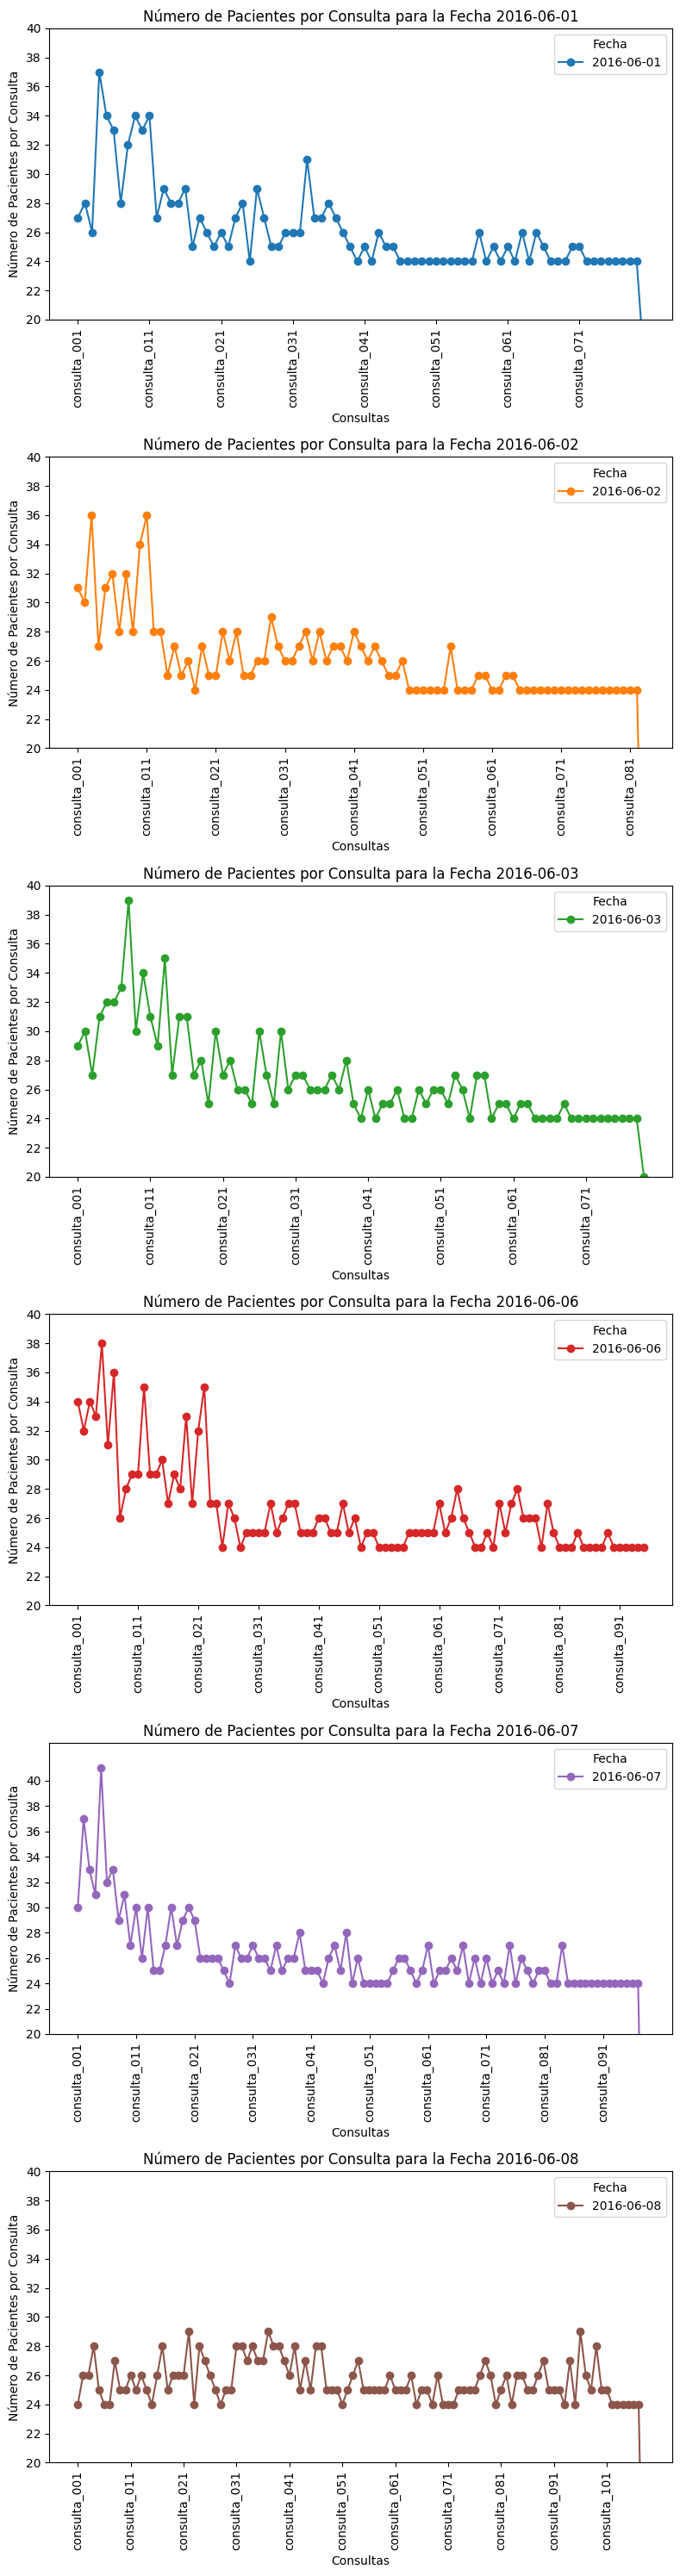

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Revisamos número de consultas por Fecha
consultas_por_fecha = []
for fecha in agenda_medica.keys():
    consultas_por_fecha.append({
        'Fecha': fecha,
        'Número Consultas': len(agenda_medica[fecha])
    })

df_consultas_por_fecha = pd.DataFrame(consultas_por_fecha)

# Revisamos número de pacientes por Consulta
pacientes_por_consulta = []
for fecha_key, consultas in agenda_medica.items():
    for consulta_key, slots in consultas.items():
        num_pacientes_por_consulta = 0
        for pacientes in slots.values(): 
            num_pacientes_por_consulta += len(pacientes)
        pacientes_por_consulta.append({
            'Fecha': fecha_key,
            'Consulta': consulta_key,
            'Número Pacientes': num_pacientes_por_consulta
        })

df_pacientes_por_consulta = pd.DataFrame(pacientes_por_consulta)
df_pacientes_por_consulta = df_pacientes_por_consulta.sort_values(by=['Fecha','Consulta'], ascending=[True, True])

# Paleta de colores
colors = list(mcolors.TABLEAU_COLORS.values())

# Creación de una gráfica por cada fecha
fechas = df_pacientes_por_consulta['Fecha'].unique()
num_fechas = len(fechas)

plt.figure(figsize=(8, 5 * num_fechas))

for i, fecha in enumerate(fechas):
    df_fecha = df_pacientes_por_consulta[df_pacientes_por_consulta['Fecha'] == fecha]
    
    plt.subplot(num_fechas, 1, i + 1)
    plt.plot(
        df_fecha['Consulta'],
        df_fecha['Número Pacientes'],
        marker='o',
        color=colors[i % len(colors)],
        label=fecha
    )

    plt.xlabel('Consultas')
    plt.ylabel('Número de Pacientes por Consulta')
    plt.title(f'Número de Pacientes por Consulta para la Fecha {fecha}')
    plt.legend(title='Fecha')
    plt.xticks(ticks=range(0, len(df_fecha['Consulta']), 10), rotation=90)
    plt.yticks(ticks=range(0,41,2))
    plt.ylim(bottom=20)
    plt.tight_layout()

plt.show()

In [16]:
# Calculamos la media de pacientes por consulta para cada fecha
df_media_pacientes_por_consulta = df_pacientes_por_consulta.groupby('Fecha')['Número Pacientes'].mean().reset_index()
df_media_pacientes_por_consulta.columns = ['Fecha', 'Media Pacientes por Consulta']

# Añadimos los resultados al DataFrame df_consultas_por_fecha
df_consultas_por_fecha = pd.merge(
    df_consultas_por_fecha,
    df_media_pacientes_por_consulta[['Fecha', 'Media Pacientes por Consulta']],
    on='Fecha',
    how='left'
)

df_consultas_por_fecha

Fecha  Número Consultas  Media Pacientes por Consulta
0  2016-06-03                79                     26.645570
1  2016-06-01                80                     26.100000
2  2016-06-08               108                     25.462963
3  2016-06-06                95                     26.547368
4  2016-06-02                83                     25.867470
5  2016-06-07                98                     25.938776

### 2.2 Cálculo de Costes: Idle Time, Waiting Time y Over Time

In [17]:
def convertir_a_dict (df_agenda_medica: pd.DataFrame) -> dict:
    # Convertir el DataFrame a diccionario con la estructura deseada
    dict_agenda_medica = {}

    for _, row in df_agenda_medica.iterrows():
        fecha = row['Fecha']
        consulta = row['Consulta']
        slot = row['Slot']
        paciente_id = row['Paciente_ID']
        
        if fecha not in dict_agenda_medica:
            dict_agenda_medica[fecha] = {}
        if consulta not in dict_agenda_medica[fecha]:
            dict_agenda_medica[fecha][consulta] = {}
        if slot not in dict_agenda_medica[fecha][consulta]:
            dict_agenda_medica[fecha][consulta][slot] = []
            
        dict_agenda_medica[fecha][consulta][slot].append(paciente_id)

    return dict_agenda_medica

def calc_exp_wc(indice: int) -> float:
    y_sup = ((indice+1)**2 + (indice+1)) / 2
    y_inf = ((indice)**2 + (indice)) / 2
    coste_exp = y_sup - y_inf
    return coste_exp

def calculo_costes_con_prob(set:pd.DataFrame,
                            df_agenda_medica:pd.DataFrame,
                            idle_minute_cost: float,
                            waiting_minute_cost: float,
                            overtime_minute_cost: float,
                            num_consultas: int) -> list:

    # Convertimos el DataFrame en un Diccionario
    dict_agenda_medica = convertir_a_dict(df_agenda_medica)

    idle_costs = {}   # Diccionario de Costos de inactividad del doctor
    waiting_costs = {}   # Diccionario de Costos de espera del paciente
    overtime_costs = {}   # Diccionario de Costos de tiempo extra del doctor

    for fecha_key, consultas in dict_agenda_medica.items():
        idle_costs[fecha_key] = {}
        waiting_costs[fecha_key] = {}
        overtime_costs[fecha_key] = {}

        consulta = 0
        for consulta_key, slots in consultas.items():
            # Recorremos el bucle sólo para el primer num_consultas indicadas
            consulta += 1
            if consulta > num_consultas:
                break
            print(f'{fecha_key} {consulta_key}:')
            # Parámetros iniciales
            idle_cost_name = f'Idle Cost {consulta_key}'
            waiting_cost_name = f'Waiting Cost {consulta_key}'
            overtime_cost_name = f'Overtime Cost {consulta_key}'
            idle_costs[fecha_key][idle_cost_name] = 24   # Coste máximo, no se ha pasado ninguna consulta.
            print(f'\nIdle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')
            waiting_costs[fecha_key][waiting_cost_name] = 0   # Coste mínimo, nadie ha esperado.
            print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
            overtime_costs[fecha_key][overtime_cost_name] = 0   # Coste mínimo, sin trabajo extra.
            print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}\n')

            patients_waiting_at_13 = 0   # Pacientes esperando a medio día
            patients_waiting_at_18 = 0   # Pacientes esperanto por la tarde
            
            slot = 1  # Primer Slot
            for slot_key, pacientes in slots.items():
                slot_ocupado = False   # Inicialmente
                print(f'Slot {slot}')
                idx_insertion = 0
                print(f'\tIdx_insertion = {idx_insertion}')

                for paciente in pacientes:
                    print(f'\tPaciente {paciente} - Slot_ocupado = {slot_ocupado}')
                    paciente_row_index = set[set['PatientId'] == paciente].index
                    print(f"\t¿Faltó a la cita? {set.loc[paciente_row_index, 'NoShow'].any()}")
                    if slot_ocupado and set.loc[paciente_row_index, 'NoShow'].any() == False:
                        if slot == 12:
                            if patients_waiting_at_13 >= 3:
                                print(f'¡OJO! El doctor no tiene el tiempo para \
atender a este paciente {paciente} de 13:00 a 14:00.\nSe mueve al slot de las 14:00.')
                                waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_13+idx_insertion)
                                print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                slot_name = f'slot_{slot+1:02d}'
                                slots[slot_name].insert(idx_insertion, paciente)
                                idx_insertion += 1
                                print(f'\tIdx_insertion = {idx_insertion}')
                            else:
                                overtime_costs[fecha_key][overtime_cost_name] += 1
                                print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}')           
                                waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_13)
                                print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                patients_waiting_at_13 += 1
                                print(f'\tPatients waiting at 13:00: {patients_waiting_at_13}')
                        elif slot == 24:
                            overtime_costs[fecha_key][overtime_cost_name] += 1
                            print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}')
                            waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_18)
                            print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                            patients_waiting_at_18 += 1
                            print(f'\tPatients waiting at 18:00: {patients_waiting_at_18}')
                        else:
                            waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(idx_insertion)
                            print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                            slot_name = f'slot_{slot+1:02d}'
                            slots[slot_name].insert(idx_insertion, paciente)
                            idx_insertion += 1
                            print(f'\tIdx_insertion = {idx_insertion}')
                    elif set.loc[paciente_row_index, 'NoShow'].any() == False:
                        slot_ocupado = True
                        idle_costs[fecha_key][idle_cost_name] -= 1
                        print(f'Idle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')

                slot += 1

            
            # Monetizamos costes
            duracion_slot = 20   # 20 minutos
            idle_costs[fecha_key][idle_cost_name] *= idle_minute_cost * duracion_slot
            print(f'\nIdle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')
            waiting_costs[fecha_key][waiting_cost_name] *= waiting_minute_cost * duracion_slot
            print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
            overtime_costs[fecha_key][overtime_cost_name] *= overtime_minute_cost * duracion_slot
            print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}\n')
            

    average_idle_costs = {}
    for fecha_key, consultas_cost in idle_costs.items():
        average_idle_costs[fecha_key] = 0
        for idle_cost in consultas_cost.values():
            average_idle_costs[fecha_key] += idle_cost
        average_idle_costs[fecha_key] /= num_consultas
    df_average_idle_costs = pd.DataFrame(average_idle_costs, index=[0])
    print(f'La media de los Costes de Inactividad es de:')
    print(df_average_idle_costs,'\n')

    average_waiting_costs = {}
    for fecha_key, consultas_cost in waiting_costs.items():
        average_waiting_costs[fecha_key] = 0
        for waiting_cost in consultas_cost.values():
            average_waiting_costs[fecha_key] += waiting_cost
        average_waiting_costs[fecha_key] /= num_consultas
    df_average_waiting_costs = pd.DataFrame(average_waiting_costs, index=[0])
    print(f'La media de los Costes de Espera de los Pacientes es de:')
    print(df_average_waiting_costs,'\n')

    average_overtime_costs = {}
    for fecha_key, consultas_cost in overtime_costs.items():
        average_overtime_costs[fecha_key] = 0
        for overtime_cost in consultas_cost.values():
            average_overtime_costs[fecha_key] += overtime_cost
        average_overtime_costs[fecha_key] /= num_consultas
    df_average_overtime_costs = pd.DataFrame(average_overtime_costs, index=[0])
    print(f'La media de los Costes de Tiempo Extra de los Doctores es de:')
    print(df_average_overtime_costs,'\n')
    
    costs = {'idle_costs': idle_costs,
            'waiting_costs': waiting_costs,
            'overtime_costs': overtime_costs}
    average_costs = {'average_idle_cost': average_idle_costs,
                    'average_waiting_cost': average_waiting_costs,
                    'average_overtime_cost': average_overtime_costs}
    
    return costs, average_costs

In [20]:
print('\033[1mHIPÓTESIS: Regla de Asignación de Cita\n \
\t\tPor Probabilidades de Asistencia\033[0m\n')

print('Set TEST con las Citas Médicas agendadas del 1 al 8 de junio:\n')
costes_ProbShow, media_costes_ProbShow = calculo_costes_con_prob(
    set = new_test_set,
    df_agenda_medica = df_agenda_medica,
    idle_minute_cost = 5,
    waiting_minute_cost = 0.5,
    overtime_minute_cost = 7,
    num_consultas = 40
)
print('------------------------------------------------------------------\
-------------------------------------------------------------------------\n')

HIPÓTESIS: Regla de Asignación de Cita
 		Por Probabilidades de Asistencia

Set TEST con las Citas Médicas agendadas del 1 al 8 de junio:

2016-06-01 consulta_001:

Idle Cost [2016-06-01 consulta_001] -> 24
Waiting Cost [2016-06-01 consulta_001] -> 0
Overtime Cost [2016-06-01 consulta_001] -> 0

Slot 1
	Idx_insertion = 0
	Paciente 79816568214259 - Slot_ocupado = False
	¿Faltó a la cita? True
Slot 2
	Idx_insertion = 0
	Paciente 529431463548 - Slot_ocupado = False
	¿Faltó a la cita? True
Slot 3
	Idx_insertion = 0
	Paciente 652678625731 - Slot_ocupado = False
	¿Faltó a la cita? False
Idle Cost [2016-06-01 consulta_001] -> 23
Slot 4
	Idx_insertion = 0
	Paciente 3624378872786 - Slot_ocupado = False
	¿Faltó a la cita? True
Slot 5
	Idx_insertion = 0
	Paciente 939919265925899 - Slot_ocupado = False
	¿Faltó a la cita? True
Slot 6
	Idx_insertion = 0
	Paciente 36177613734693 - Slot_ocupado = False
	¿Faltó a la cita? False
Idle Cost [2016-06-01 consulta_001] -> 22
Slot 7
	Idx_insertion = 0
	Pacien

In [21]:
# Función Exportar el DataFrame a Excel

def exportar_tabla_resumen_a_excel(tabla: pd.DataFrame, regla: str) -> None:
    '''
    Exporta un DataFrame a un archivo de Excel con formato personalizado.

    La función toma un DataFrame y una cadena de texto que representa una Regla de Asignación de Cita.
    Crea un archivo de Excel con el DataFrame, añade un título basado en la regla,
    centra el texto de las celdas, aplica un formato numérico a ciertas columnas,
    ajusta el ancho de las columnas y guarda el archivo con un nombre basado en la regla.

    Parámetros:
    tabla (pd.DataFrame): El DataFrame a exportar.
    regla (str): Una cadena de texto que se utilizará para personalizar el nombre del archivo y el título de la hoja de cálculo.

    Retorno:
    None: La función no retorna ningún valor, pero guarda un archivo de Excel en el directorio actual.

    Ejemplo:
    >>> df = pd.DataFrame({
            'A': [1, 2, 3],
            'B': [4, 5, 6],
            'C': [7.1234, 8.5678, 9.9101]
        })
    >>> exportar_tabla_resumen_a_excel(df, 'Ejemplo')
    El DataFrame ha sido exportado exitosamente a Costes_promedio_Ejemplo.xlsx.
    '''
    # Crear un nuevo workbook
    wb = Workbook()
    ws = wb.active

    # Añadir el título
    ws.merge_cells('A1:F1')
    nombre_tabla = 'Costes Promedio Hipótesis ' + regla
    ws['A1'] = nombre_tabla
    ws['A1'].alignment = Alignment(horizontal = 'center')

    # Añadir el DataFrame a la hoja de cálculo
    for r_idx, row in enumerate(dataframe_to_rows(tabla, index = False, header = True), 2):
        for c_idx, value in enumerate(row, 1):
            cell = ws.cell(row = r_idx, column = c_idx, value = value)
            cell.alignment = Alignment(horizontal='center')
            if isinstance(value, float) and c_idx > 2:
                cell.number_format = '0.0000'

    # Ajustar el ancho de las columnas
    for col in ws.iter_cols(min_row = 2,
                            max_row = ws.max_row,
                            min_col = 1,
                            max_col = ws.max_column):
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            if cell.coordinate in ws.merged_cells:  # no considerar celdas fusionadas
                continue
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width

    # Guardar el archivo
    nombre_archivo = 'Costes_promedio_' + regla + '.xlsx'
    wb.save(nombre_archivo)

    # Mostrar mensaje de confirmación
    print(f'El DataFrame ha sido exportado exitosamente a {nombre_archivo}.')
    
    return None

In [28]:
# Crear la Tabla RESUMEN con los costes medios para esta Regla de Asignación de Citas R11
data_ProbShow = {
    'Fecha': [fecha for fecha in costes_ProbShow['idle_costs'].keys()],
    'Consultas': [
        len(costes_ProbShow['idle_costs'][fecha])
        for fecha in costes_ProbShow['idle_costs'].keys()
    ],
    'Idle Cost': [
        media_costes_ProbShow['average_idle_cost'][fecha]
        for fecha in media_costes_ProbShow['average_idle_cost'].keys()
    ],
    'Waiting Cost': [
        media_costes_ProbShow['average_waiting_cost'][fecha]
        for fecha in media_costes_ProbShow['average_waiting_cost'].keys()
    ],
    'Overtime Cost': [
        media_costes_ProbShow['average_overtime_cost'][fecha]
        for fecha in media_costes_ProbShow['average_overtime_cost'].keys()
    ]
}

tabla_resumen_ProbShow = pd.DataFrame(data_ProbShow)

exportar_tabla_resumen_a_excel(tabla_resumen_ProbShow, 'ProbShow')

# Mostrar el DataFrame
tabla_resumen_ProbShow

El DataFrame ha sido exportado exitosamente a Costes_promedio_ProbShow.xlsx.


Fecha  Consultas  Idle Cost  Waiting Cost  Overtime Cost
0  2016-06-01         40      437.5         72.75          108.5
1  2016-06-02         40      495.0         86.50           80.5
2  2016-06-03         40      507.5         75.25          101.5
3  2016-06-06         40      542.5         80.50          115.5
4  2016-06-07         40      452.5         88.50          105.0
5  2016-06-08         40      505.0         27.00           31.5